# Hello,

## and welcome to this notebook. This code is one part of a two-part post. The writeup of this analysis is present on my [Medium page](https://medium.com/@alitaimurshabbir) under the title:

## "The Ebb and Flow of A Battle Royale Game or: A Guide To Sucking Less Through Pretty Graphs"

In [1]:
#import libraries
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

#set graph styles
sns.set(style="darkgrid")
import matplotlib.style as style
style.use('fivethirtyeight')

#set fonts
hfont = {'fontname':'Decima Mono X'}
ofont = {'fontname':'Decima Mono Pro'}
afont = {'fontname':'Atlas Grotesk'}

# Load PUBG data

In [2]:
#deaths data
n = 100  # every 100th line = 1% of the lines
deathsAsRows = pd.read_csv('.../pubg-match-deaths/deaths/kill_match_stats_final_0.csv', 
                            header=0, skiprows=lambda i: i % n != 0)

In [3]:
#aggregate data
n = 750  # every 100th line = 1% of the lines
matchesAsRows = pd.read_csv('.../pubg-match-deaths/aggregate/agg_match_stats_0.csv', 
                            header=0, skiprows=lambda i: i % n != 0)

In [4]:
#get quick summary of deaths data
from pandas_profiling import ProfileReport
prof = ProfileReport(deathsAsRows)
#prof.to_file(output_file='report.html')
prof

/opt/anaconda3/lib/python3.7/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/opt/anacond

In [5]:
#restrict deaths data to Erangel
erangel = deathsAsRows[deathsAsRows['map'] == 'ERANGEL']

In [6]:
#number of observations
len(erangel)

108709

# Locations

<font color='red'> 

## Areas Where Players Die Most Frequently

</font> 


Scale coordinates as recommended by provider of data, user [KP](https://www.kaggle.com/skihikingkevin/pubg-match-deaths) on Kaggle

### Scaling coordinates: Killer, X

In [7]:
from sklearn import preprocessing
MM_scaler = preprocessing.MinMaxScaler()

scaled_killer_position_x = MM_scaler.fit_transform(erangel['killer_position_x'].values.reshape(-1,1))
scaled_killer_position_y = MM_scaler.fit_transform(erangel['killer_position_y'].values.reshape(-1,1))

#finding and filling missing data
print(erangel['killer_position_x'].isnull().sum())
pd.DataFrame(erangel['killer_position_x'].fillna(method='pad',inplace=True))

#convert array into Series after reshaping
scaled_killer_position_x = pd.Series(scaled_killer_position_x.reshape(-1))

#fill in missing values for histogram
#scaled_killer_position_x.fillna(method='pad',inplace = True)

7576


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Scaling coordinates: Killer, Y

In [8]:
#find and fill missing values
print(erangel['killer_position_y'].isnull().sum())
erangel['killer_position_y'].fillna(method='pad',inplace=True)

#convert array into Series after reshaping
scaled_killer_position_y = pd.Series(scaled_killer_position_y.reshape(-1))

#fill in missing values for histogram
#scaled_killer_position_y.fillna(method='pad',inplace = True)

7576


### Scaling coordinates: Victim, X

In [9]:
#find and fill missing values for unscaled data
print(erangel['victim_position_x'].isnull().sum())

#scale and transform
MM_scaler = preprocessing.MinMaxScaler()
scaled_victim_position_x = MM_scaler.fit_transform(erangel['victim_position_x'].values.reshape(-1,1))

#turn into Series after reshaping
scaled_victim_position_x = pd.Series(scaled_victim_position_x.reshape(-1))

0


### Scaling coordinates: Victim, Y

In [10]:
#find and fill missing values for unscaled data
print(erangel['victim_position_y'].isnull().sum())

#scale and transform
MM_scaler = preprocessing.MinMaxScaler()
scaled_victim_position_y = MM_scaler.fit_transform(erangel['victim_position_y'].values.reshape(-1,1))

#turn into Series after reshaping
scaled_victim_position_y = pd.Series(scaled_victim_position_y.reshape(-1))

0


In [11]:
#define bound box

BBox = ((scaled_victim_position_x.min(), scaled_victim_position_x.max(),      
         scaled_victim_position_y.min(), scaled_victim_position_y.max()))

In [12]:
#load image

map_ = plt.imread('.../pubg-match-deaths/erangel.jpg')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Atlas Grotesk'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Decima Mono X'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Decima Mono Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


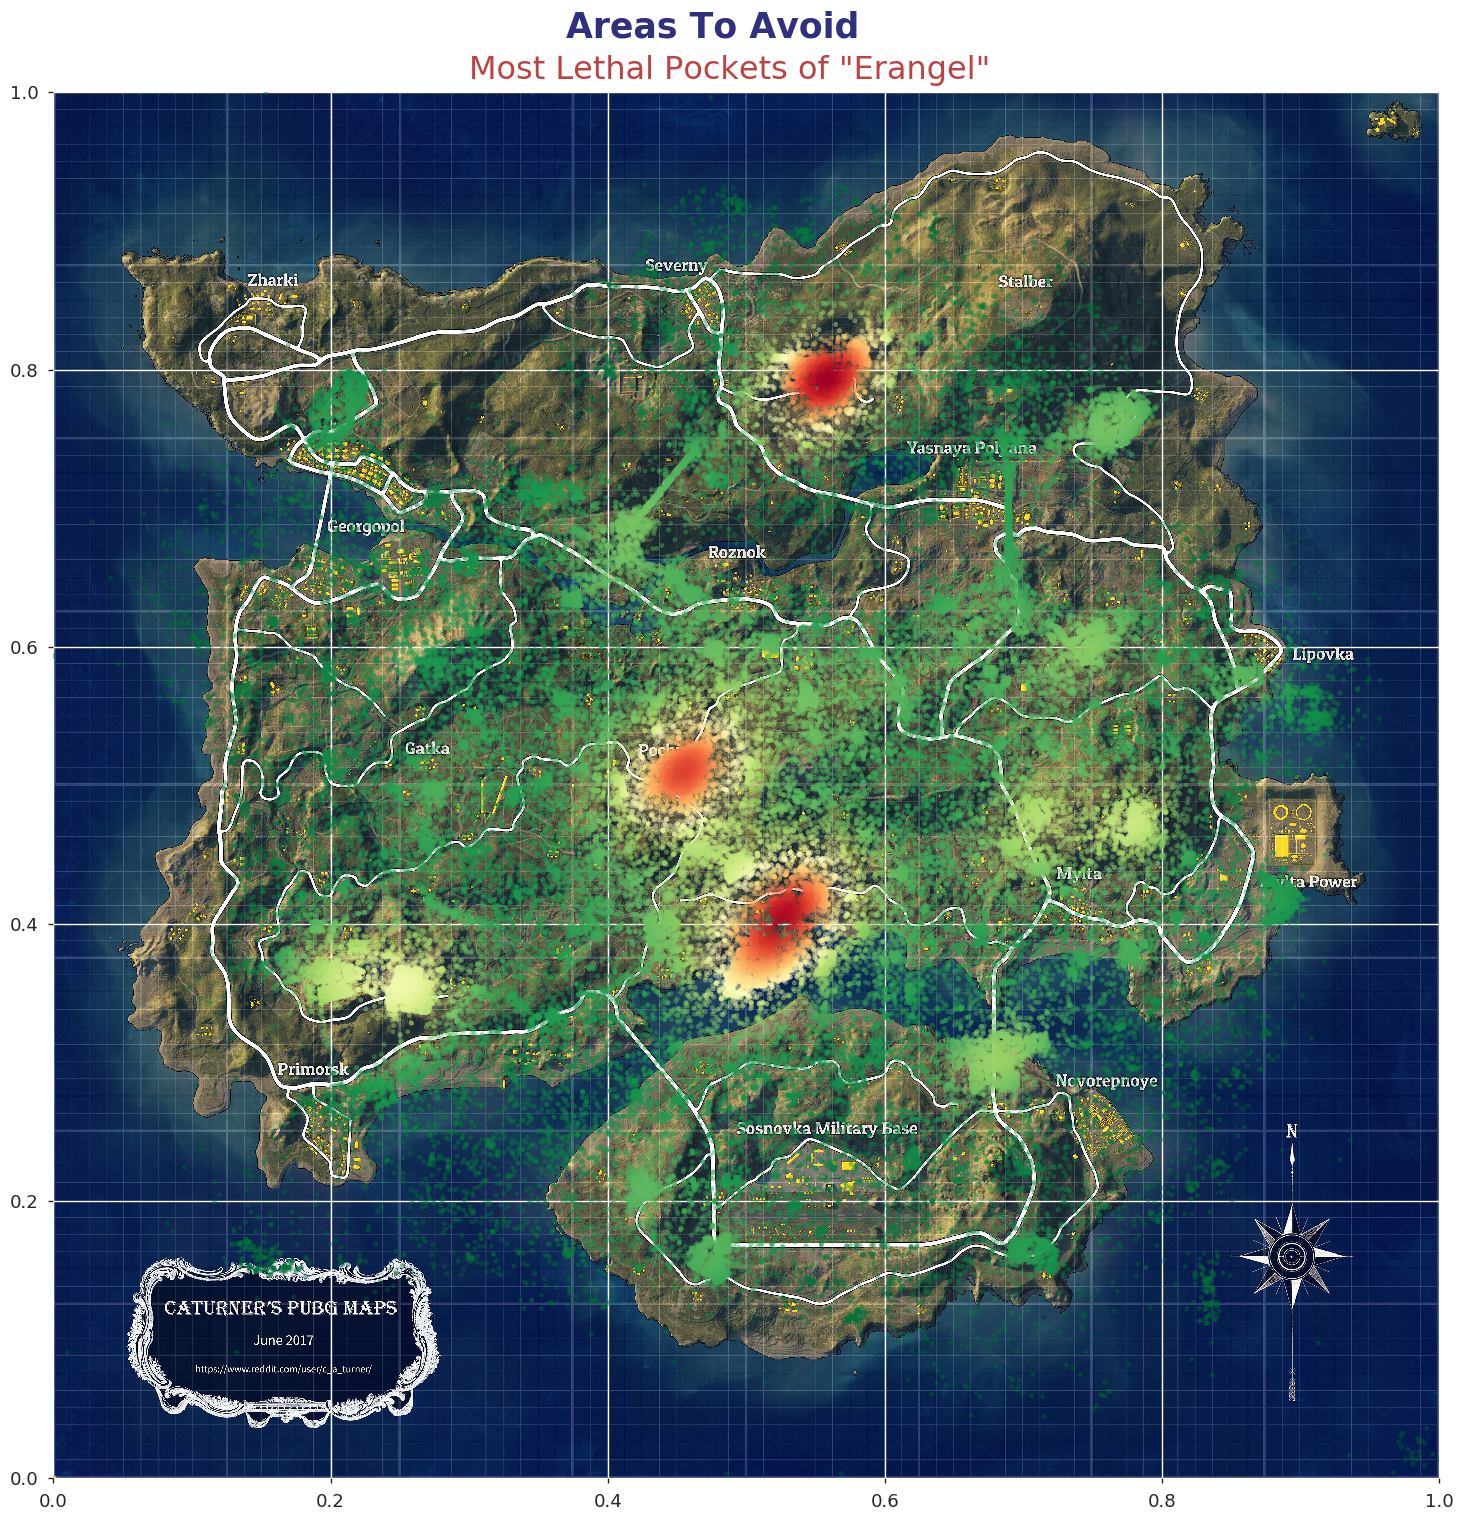

In [13]:
#plot data as scatter points over image

fig, ax = plt.subplots(figsize = (18,18))

x = scaled_victim_position_x
y = scaled_victim_position_y

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z, cmap = 'RdYlGn_r',s=10, alpha = 0.4)

ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

plt.text(x = 0.37, y = 1.04, s = "Areas To Avoid",
               fontsize = 25, weight = 'bold', alpha = .9, color = 'midnightblue',**hfont)
plt.text(x = 0.3, y = 1.01, s = 'Most Lethal Pockets of "Erangel"', fontsize = 23, alpha = .85,
        color = 'firebrick',**ofont)


plt.xticks(**afont,fontsize=14)
plt.yticks(**afont,fontsize=14)

plt.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax.imshow(map_, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

<font color='red'> 
    
## Differences in Killer-Victim Placements


</font> 

In [14]:
#using deaths data (across both maps)

#create difference variable
deathsAsRows['Difference in Victim-Killer Placement'] = deathsAsRows['victim_placement'] - deathsAsRows['killer_placement']

In [15]:
deathsAsRows['Difference in Victim-Killer Placement'].isnull().sum() #check missing values

#drop all rows where value in new variable is missing
killer_victim_diff_df = deathsAsRows[deathsAsRows['Difference in Victim-Killer Placement'].notna()]

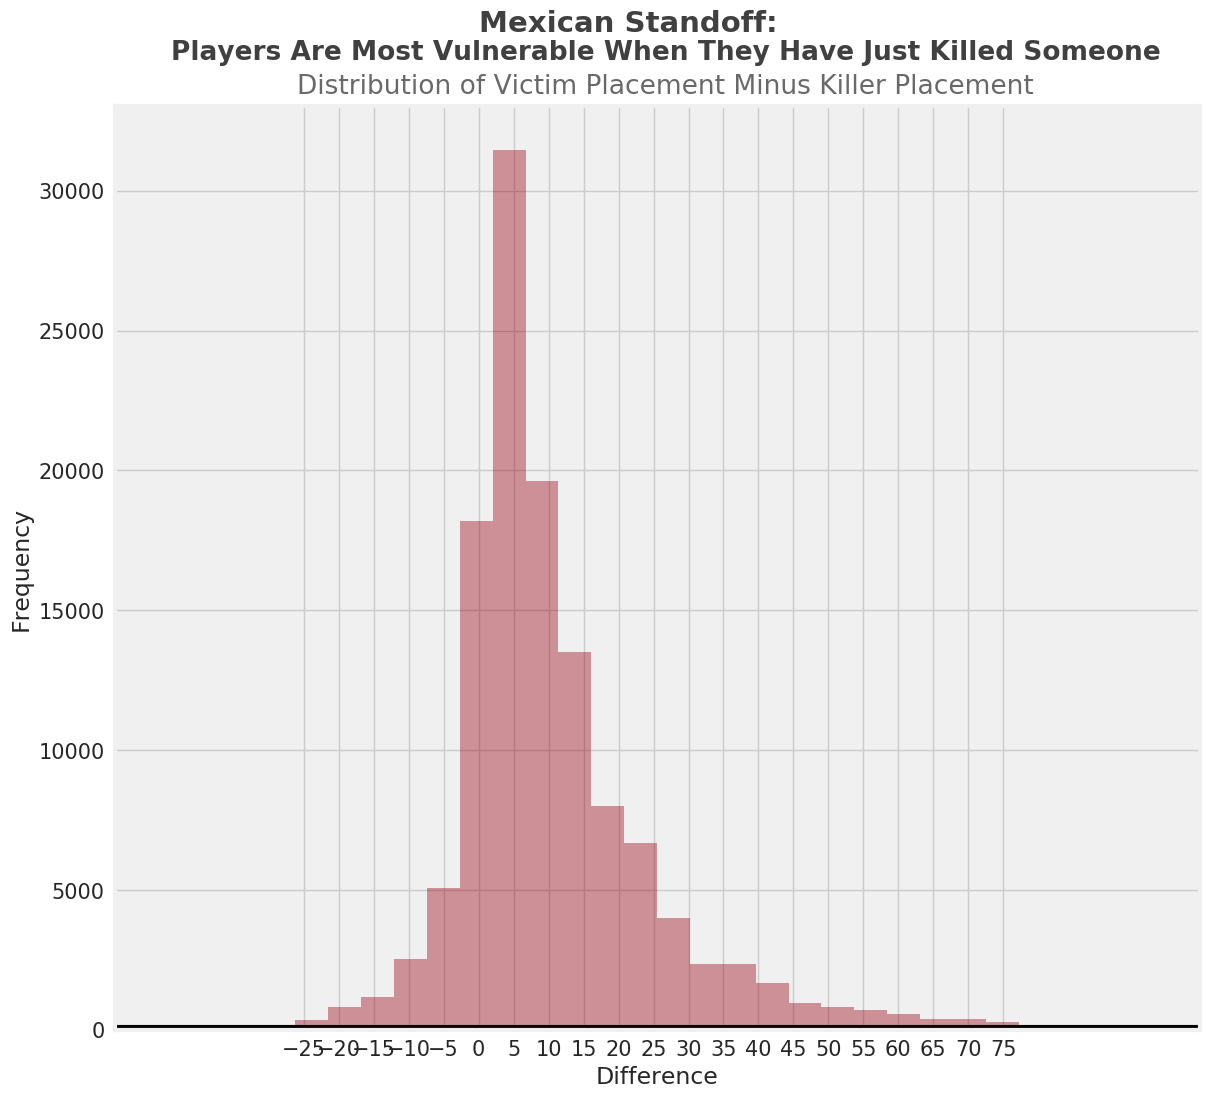

In [16]:
plt.figure(figsize=(14,12))
plt.style.use('fivethirtyeight')

sns.distplot(killer_victim_diff_df['Difference in Victim-Killer Placement'], kde=False, bins=30, color = '#990011FF')


plt.xlabel('Difference',fontsize=17,**afont)
plt.ylabel('Frequency',fontsize=17,**afont)

xticks = range(-25,80,5)
plt.xticks(xticks,**afont)
plt.yticks(**afont)


plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.axhline(y = 0, color = 'black', linewidth = 8, alpha = 1)


plt.text(x = 0, y = 35700, s = "Mexican Standoff:",
               fontsize = 21, weight = 'bold', alpha = .75, color = 'black',**hfont)

plt.text(x = -44, y = 34700, s = "Players Are Most Vulnerable When They Have Just Killed Someone",
               fontsize = 19, weight = 'bold', alpha = .75, color = 'black',**hfont)

plt.text(x = -26, y = 33500, s = 'Distribution of Victim Placement Minus Killer Placement', fontsize = 19, alpha = 1,
        color = 'dimgrey',**ofont)
plt.show()

# Weapons and Kills

<font color='red'> 

## 12 Deadliest Weapons

</font> 


Create copy of **deaths** dataframe and name it **causeOfDeath**

In [17]:
#create dataframe of Weapon and Kills Per Weapon using Value Counts
causeOfDeath = pd.DataFrame(deathsAsRows['killed_by'].value_counts()) #get number of kills
causeOfDeath.reset_index(inplace=True)
causeOfDeath.columns = ['Weapon', 'Number of Kills'] #rename columns

#get top 12 entries based on number of kills for easier visualisation
causeOfDeath = causeOfDeath[causeOfDeath['Number of Kills']>2878]

In [18]:
#Add new column detailing the type of each weapon
causeOfDeath['Type of Weapon'] = ""

causeOfDeath.loc[causeOfDeath['Weapon']=='Down and Out','Type of Weapon'] = 'Environmental Hazard'
causeOfDeath.loc[causeOfDeath['Weapon']=='M416','Type of Weapon'] = 'Assault Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='SCAR-L','Type of Weapon'] = 'Assault Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='M16A4','Type of Weapon'] = 'Assault Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='AKM','Type of Weapon'] = 'Assault Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='UMP9','Type of Weapon'] = 'SMG'
causeOfDeath.loc[causeOfDeath['Weapon']=='Bluezone','Type of Weapon'] = 'Environmental Hazard'
causeOfDeath.loc[causeOfDeath['Weapon']=='S1897','Type of Weapon'] = 'Shotgun'
causeOfDeath.loc[causeOfDeath['Weapon']=='Mini 14','Type of Weapon'] = 'Semi-Automatic Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='Kar98k','Type of Weapon'] = 'Semi-Automatic Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='S686','Type of Weapon'] = 'Shotgun'
causeOfDeath.loc[causeOfDeath['Weapon']=='SKS','Type of Weapon'] = 'Semi-Automatic Rifle'
causeOfDeath.loc[causeOfDeath['Weapon']=='S12K','Type of Weapon'] = 'Shotgun'

In [19]:
#preview dataframe and drop non-weapon causes of death
causeOfDeath.drop([9,0],inplace = True)
causeOfDeath

Weapon  Number of Kills        Type of Weapon
1       M416            15457         Assault Rifle
2     SCAR-L            12462         Assault Rifle
3      M16A4            12402         Assault Rifle
4        AKM            11309         Assault Rifle
5       UMP9             7389                   SMG
6   Bluezone             6561  Environmental Hazard
7      S1897             5880               Shotgun
8    Mini 14             4144  Semi-Automatic Rifle
10    Kar98k             3444  Semi-Automatic Rifle
11      S686             3339               Shotgun
12       SKS             3145  Semi-Automatic Rifle
13      S12K             2879               Shotgun

Visualise the top 12 weapons by kill count and weapon type

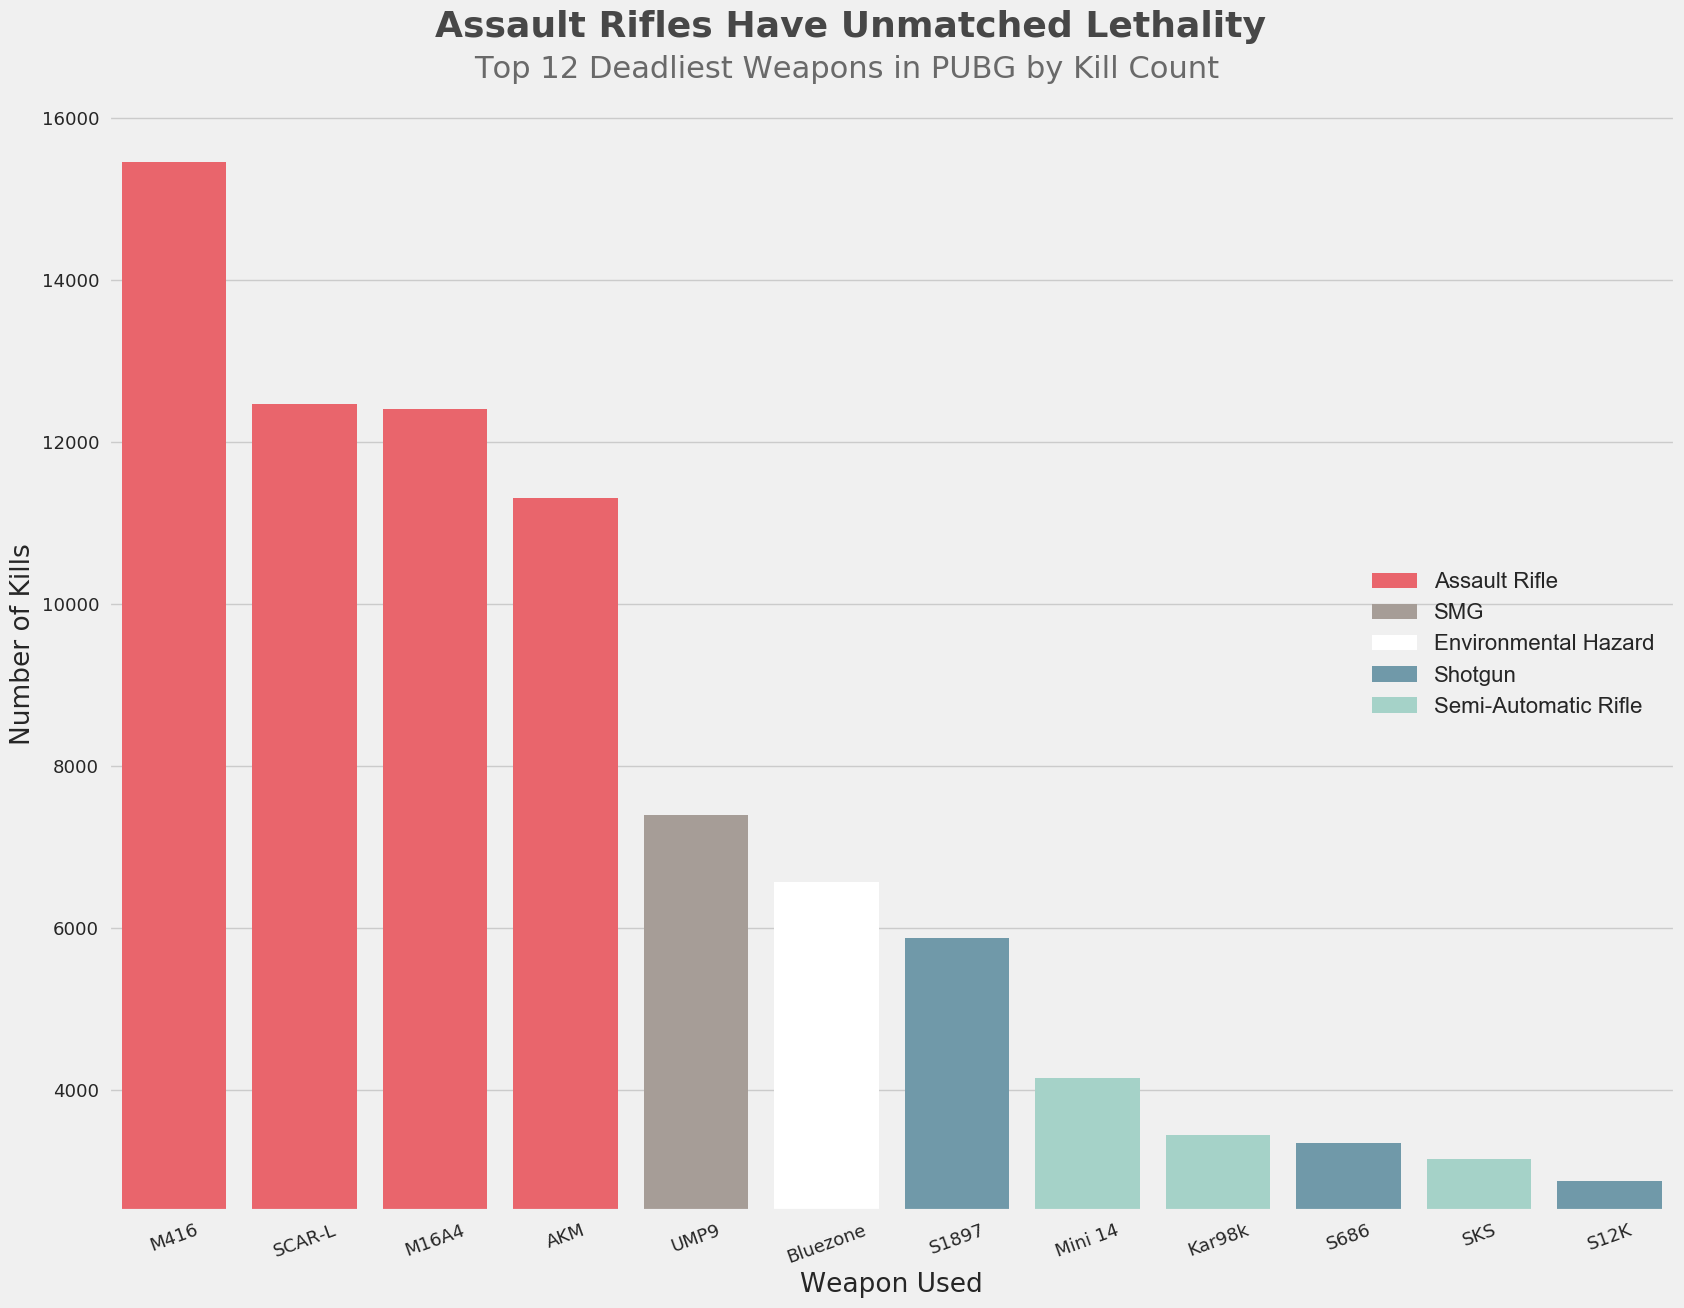

In [20]:
plt.figure(figsize=(18,14))

palette1=['#FF4F58FF','#A89C94FF','white','#669DB3FF','#9ED9CCFF']



sns.barplot(x = 'Weapon', y ='Number of Kills', hue = 'Type of Weapon', data = causeOfDeath, dodge = False, 
            palette = palette1) 

plt.legend(fontsize=16, loc = 'right')


plt.xlabel('Weapon Used',fontsize=19,**afont)
plt.ylabel('Number of Kills',fontsize=19,**afont)

plt.xticks(rotation=20,**afont,fontsize=14)
plt.yticks(**afont)

plt.ylim(2500,16500)

plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plt.axhline(y = 0, color = 'black', linewidth = 8, alpha = 1)


plt.text(x = 2, y = 17000, s = "Assault Rifles Have Unmatched Lethality",
               fontsize = 26, weight = 'bold', alpha = .7, color = 'black',**hfont)
plt.text(x = 2.3, y = 16500, s = 'Top 12 Deadliest Weapons in PUBG by Kill Count', fontsize = 22, alpha = 1,
        color = 'dimgrey',**ofont)


plt.show()



<font color='red'> 

## Distribution of Kill Range

</font> 


In [21]:
#using only data restricted to Erangel again
erangel=pd.DataFrame(erangel)

In [22]:
#create Range of Kill variable
erangel['Range of Kill']=((erangel["killer_position_x"] - erangel["victim_position_x"]) ** 2 + (erangel["killer_position_y"] - erangel["victim_position_y"]) ** 2) ** (1/2)

In [23]:
erangel['Range of Kill']

1          2932.883702
2         10299.238066
3           380.675006
4          6030.075663
5         11250.337496
              ...     
134257        0.000000
134258    26466.003412
134259      409.320706
134260      338.598582
134262     6447.024741
Name: Range of Kill, Length: 108709, dtype: float64

The range of axes in the data is 0,800000. According to the [Official PUBG Website](https://pubgmap.io/compare.html), Erangel is an 8 km x 8 km map.

This means that **100 'steps' in our 'Range of Kill' variable is equal to 1 meter of distance on the ground**. I am going to keep this convention instead of converting the distance units to meters

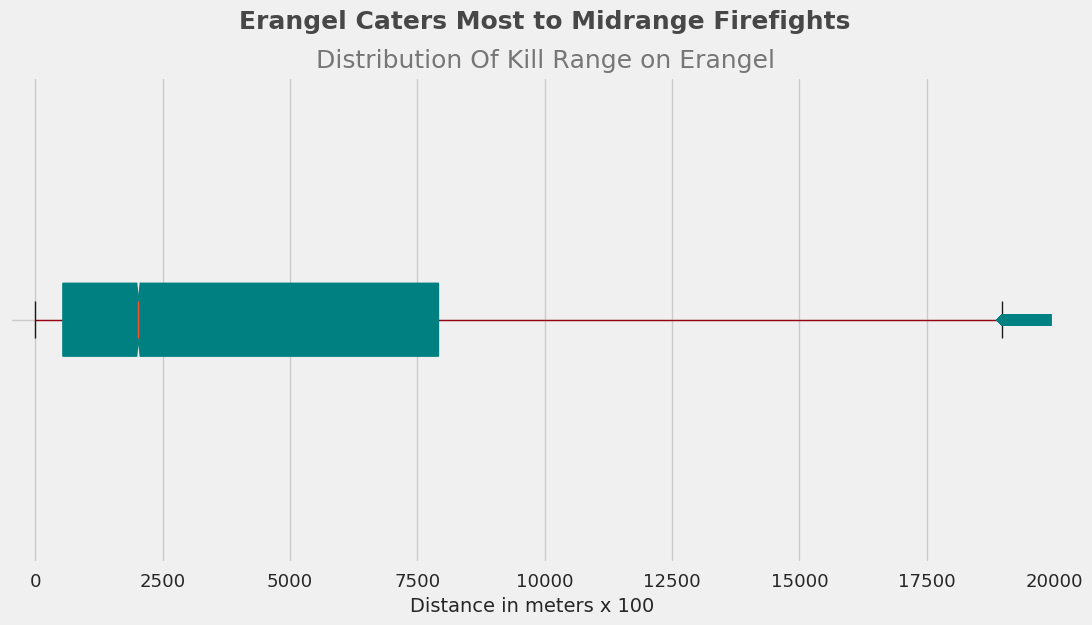

In [24]:
plt.figure(figsize=(12,6))

boxprops = dict(linestyle='--', linewidth=3, color='#990011FF')
green_diamond = dict(markerfacecolor='teal', marker='D')


plt.boxplot(erangel['Range of Kill'], labels =[""], notch = True, vert = False, patch_artist = True,
                  showcaps = True, flierprops=green_diamond, boxprops=dict(facecolor='teal',
                  color='teal'), whiskerprops=dict(color='#990011FF'))

plt.xlim(-500,20000)

plt.xlabel('Distance in meters x 100',fontsize=14,**afont)

plt.xticks(**afont,fontsize=12)
plt.yticks(**afont)

plt.tick_params(axis = 'both', which = 'major', labelsize = 13)
plt.axhline(y = 0, color = 'black', linewidth = 8, alpha = 1)


plt.text(x = 4000, y = 1.6, s = "Erangel Caters Most to Midrange Firefights",
               fontsize = 18, weight = 'bold', alpha = .7, color = 'black',**hfont)
plt.text(x = 5500, y = 1.52, s = 'Distribution Of Kill Range on Erangel', fontsize = 18, alpha = .9,
        color = 'dimgrey',**ofont)


plt.show()



<font color='red'> 

### Distribution of Kill Range by Weapon

</font> 

In [25]:
#create a new dataframe called gun_range_df that contains the top 12 deadliest weapons by kill count, then visualise
#range of kill for these weapons

gun_range_df = (erangel.loc[erangel['killed_by'].isin(['M416','M16A4','SCAR-L','AKM','UMP9','Bluezone','S1897',
                                                       'Mini 14','Kar98k','S686','SKS','S12K'])])

gun_range_df = pd.DataFrame(gun_range_df)
gun_range_df = gun_range_df.sample(frac = 0.1)#take a 10% random sample because a swarmplot works better with less data
len(gun_range_df)

7171

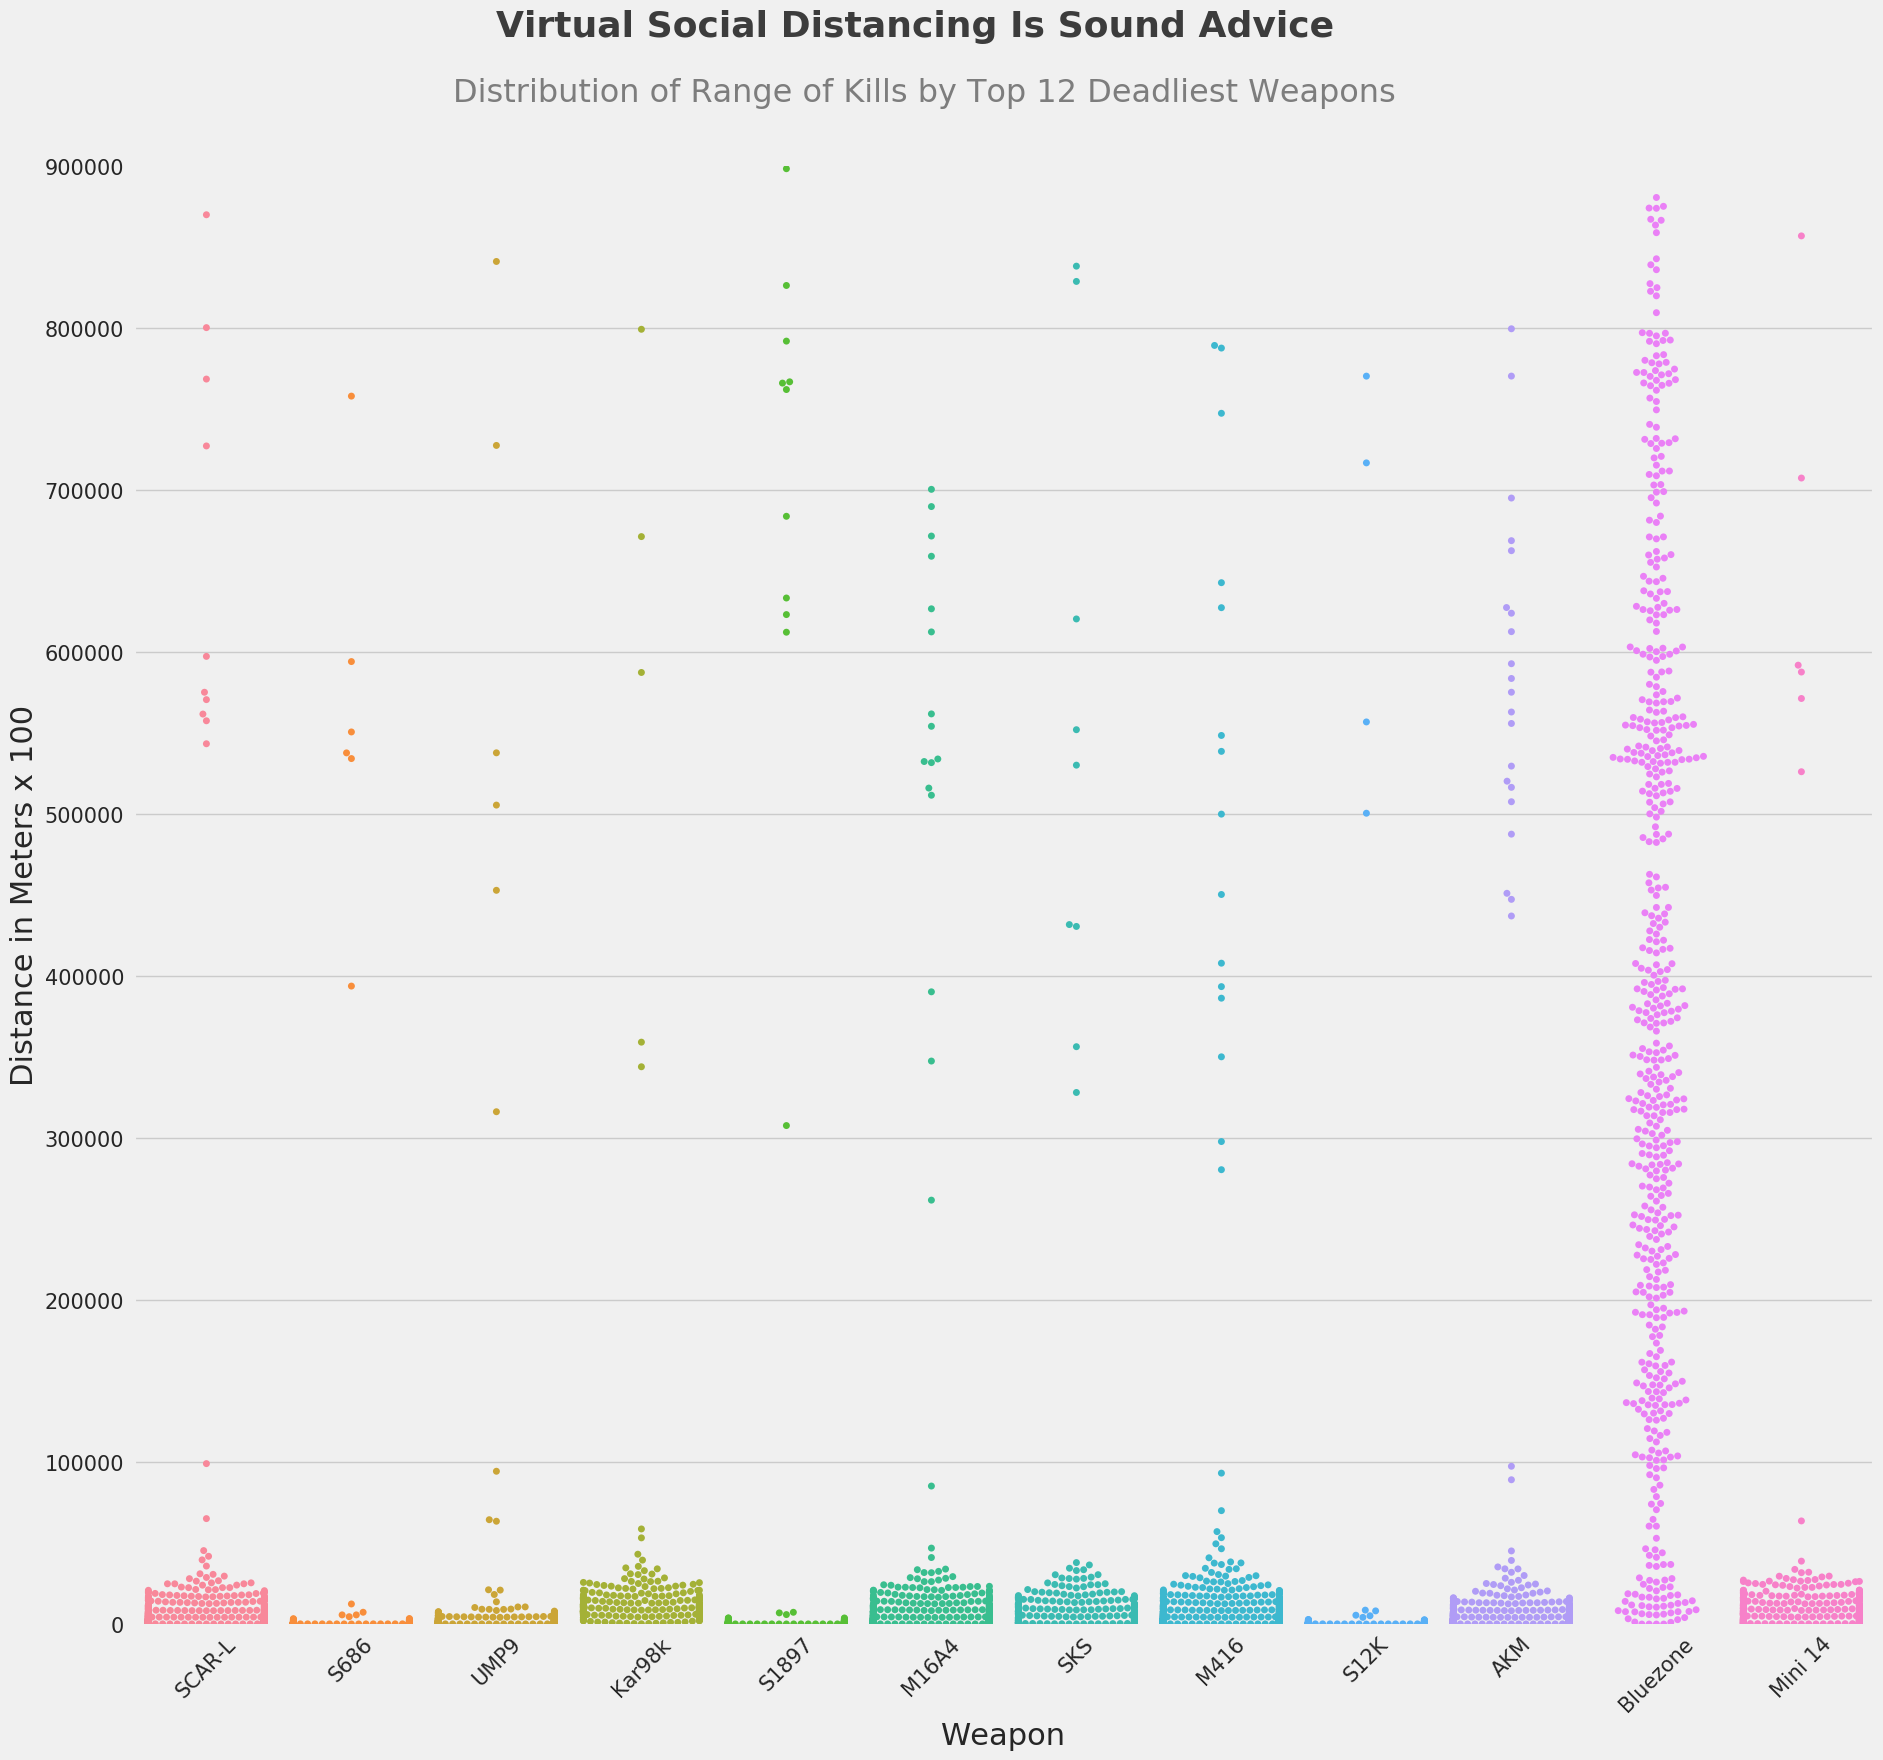

In [27]:
#swarmplot of deadliest weapons by range

plt.figure(figsize=(20,18))
plt.style.use('fivethirtyeight')
sns.swarmplot(x='killed_by', y='Range of Kill', data=gun_range_df, cmap = 'twilight')

plt.xlabel('Weapon',fontsize=22,**afont)
plt.ylabel('Distance in Meters x 100',fontsize=22,**afont)

plt.tick_params(axis = 'both', which = 'major', labelsize = 15)

plt.xticks(rotation=45,**afont)
plt.yticks(**afont)

#plt.yscale('log',basey=2)

plt.ylim(1,900000)

plt.text(x = 2, y = 980000, s = "Virtual Social Distancing Is Sound Advice",
               fontsize = 26, weight = 'bold', alpha = .75, color = 'black',**hfont)
plt.text(x = 1.7, y = 940000, s = 'Distribution of Range of Kills by Top 12 Deadliest Weapons', fontsize = 23, alpha = .85,
        color = 'dimgrey',**ofont)
plt.show()

<font color='red'> 
    
## Deadliest weapons at long range
    
</font> 

In [28]:
erangel['Range of Kill'].describe()

count    108709.000000
mean      44983.580118
std      143049.334582
min           0.000000
25%         538.444695
50%        2022.579326
75%        7913.385107
max      902024.008844
Name: Range of Kill, dtype: float64

#### We'll use the 3rd quartile of data, equal to 80 meters approximately, as the lower bound of what defines 'long range'

In [29]:
#create dataframe with kills from further than 80 meters
lethality_at_long_range_df = erangel[erangel['Range of Kill']>8000] #since 8000 units equals 80 meters

#create value counts dataframe for weapons and kill count (at range)
lethality_at_long_range_df = pd.DataFrame(lethality_at_long_range_df['killed_by'].value_counts())
lethality_at_long_range_df.reset_index(inplace=True)
lethality_at_long_range_df.columns = ['Weapon', 'Number of Kills At Range']

#restrict dataframe by Number of Kills At Range to top 10 weapons only for easier visualisation
lethality_at_long_range_df = lethality_at_long_range_df[lethality_at_long_range_df['Number of Kills At Range']>463]

In [30]:
lethality_at_long_range_df.drop([9], inplace = True) #drop 'punch' row as it is clearly erroneous
lethality_at_long_range_df

Weapon  Number of Kills At Range
0   Down and Out                      5994
1       Bluezone                      5127
2           M416                      2002
3         Kar98k                      1916
4          M16A4                      1911
5         SCAR-L                      1610
6        Mini 14                      1568
7            AKM                      1249
8            SKS                      1204
10       Falling                       729

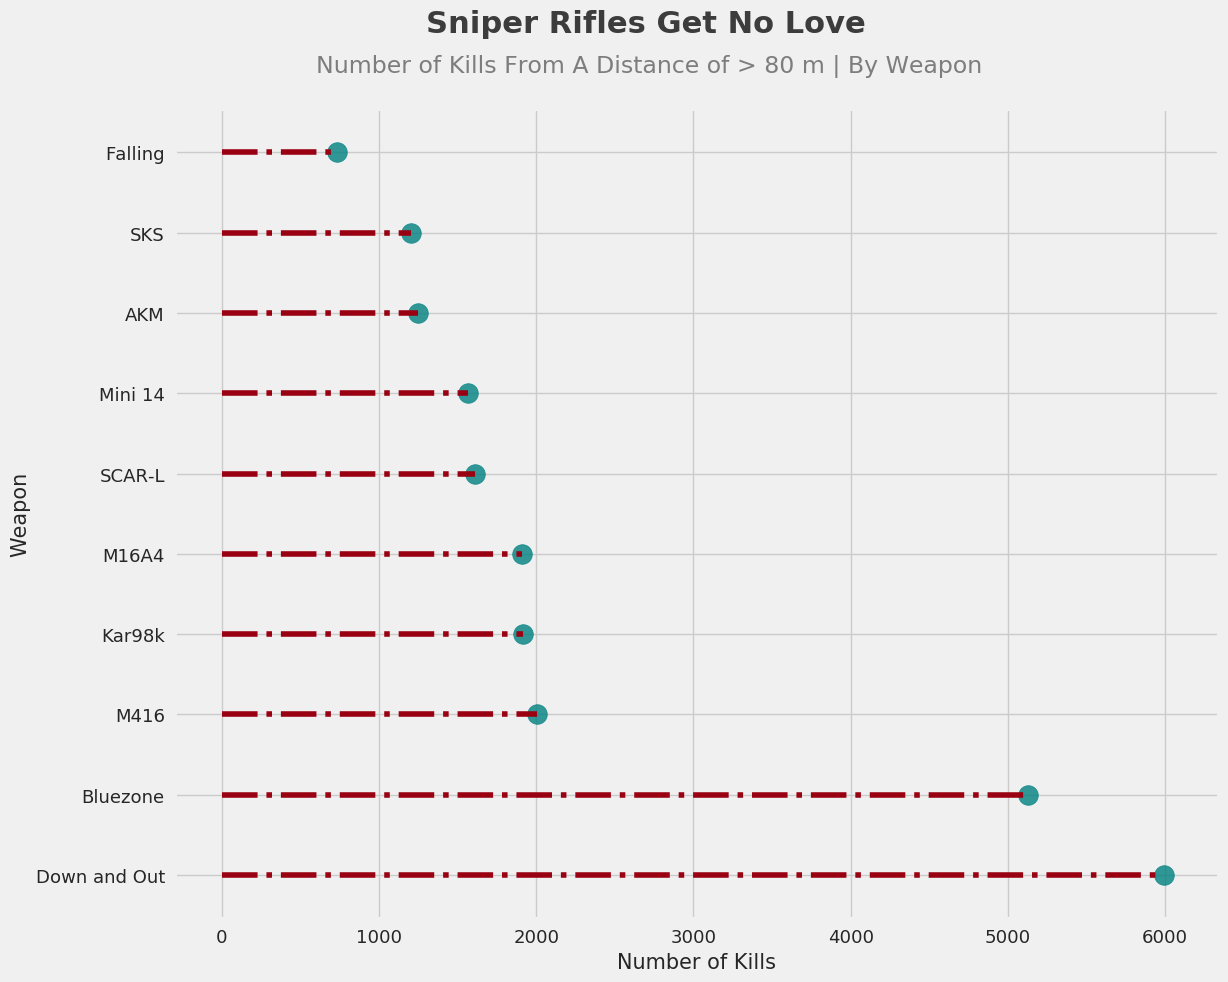

In [31]:
plt.figure(figsize=(12,10))

my_range=range(1,len(lethality_at_long_range_df.index)+1)

 
plt.hlines(y=my_range, xmin=0, xmax=lethality_at_long_range_df['Number of Kills At Range'], color='#990011FF',
           linestyles='dashdot')
#plt.plot(lethality_at_long_range_df['Number of Kills At Range'], my_range, 'o', color = '#990011FF')

plt.scatter(lethality_at_long_range_df['Number of Kills At Range'], my_range,
            color='teal', s=200, alpha=0.8)

plt.yticks(my_range, lethality_at_long_range_df['Weapon'])


plt.xlabel('Number of Kills',fontsize=15,**afont)
plt.ylabel('Weapon',fontsize=15,**afont)

plt.xticks(**afont)
plt.yticks(**afont)

plt.tick_params(axis = 'both', which = 'major', labelsize = 13)


plt.text(x = 1300, y = 11.5, s = "Sniper Rifles Get No Love",
               fontsize = 22, weight = 'bold', alpha = .75, color = 'black',**hfont)
plt.text(x = 600, y = 11, s = 'Number of Kills From A Distance of > 80 m | By Weapon', fontsize = 17, alpha = .85,
        color = 'dimgrey',**ofont)



plt.show()

# Survival and Placements

<font color='red'> 
    
## Is aggresive play a good strategy for survival?
    
</font> 

#### We start using the aggregate dataset now

In [32]:
matchesAsRows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18465 entries, 0 to 18464
Data columns (total 15 columns):
date                   18465 non-null object
game_size              18465 non-null int64
match_id               18465 non-null object
match_mode             18465 non-null object
party_size             18465 non-null int64
player_assists         18465 non-null int64
player_dbno            18465 non-null int64
player_dist_ride       18465 non-null float64
player_dist_walk       18465 non-null float64
player_dmg             18465 non-null int64
player_kills           18465 non-null int64
player_name            18437 non-null object
player_survive_time    18465 non-null float64
team_id                18465 non-null int64
team_placement         18465 non-null int64
dtypes: float64(3), int64(8), object(4)
memory usage: 2.1+ MB


In [33]:
#create new subset dataframe
kills_and_survival_time_df = pd.DataFrame(matchesAsRows)

In [34]:
#get means of all other variables by values of 'player_kills' variable
kills_and_survival_time_df = pd.DataFrame(kills_and_survival_time_df.groupby('player_kills').mean())
kills_and_survival_time_df.reset_index(inplace = True)

In [35]:
#restrict data to the 4 columns we need for analysis
kills_and_survival_time_df = pd.DataFrame(kills_and_survival_time_df.loc[:,['player_kills','party_size',
                                                                            'player_survive_time','team_placement']])

#create two separate rounding functions:


#1) to round 'party_size' to nearest 0.5 
def roundingToDecimal(series):
    return round(series * 2) / 2

kills_and_survival_time_df['Rounded Party Size'] = kills_and_survival_time_df['party_size'].map(lambda x: roundingToDecimal(x))


#2) and round 'team_placement' to nearest integer
def roundingToInteger(series):
    return int(round(series))

kills_and_survival_time_df['Rounded Team Placement'] = kills_and_survival_time_df['team_placement'].map(lambda x: roundingToInteger(x))

In [36]:
#preview dataframe
kills_and_survival_time_df

player_kills  party_size  player_survive_time  team_placement  \
0              0    2.745321           621.554914       28.575193   
1              1    2.695977           836.941594       23.071942   
2              2    2.646460          1020.523711       18.540499   
3              3    2.803222          1207.600137       13.735328   
4              4    2.712245          1348.156729       11.193878   
5              5    2.799283          1501.981111        8.204301   
6              6    2.568493          1549.759822        7.897260   
7              7    2.836957          1634.820554        5.510870   
8              8    2.511628          1745.262070        4.325581   
9              9    3.088235          1661.831088        5.000000   
10            10    2.736842          1760.075368        2.842105   
11            11    2.777778          1690.744167        3.833333   
12            12    2.200000          1763.058200        2.000000   
13            13    3.666667          1792.890833        1.000000   
14            14    1.666667          1768.877667        2.333333   
15            15    3.333333          1739.032667        1.000000   
16            16    4.000000          1773.995000        1.000000   
17            17    3.000000          1779.407500        2.000000   

    Rounded Party Size  Rounded Team Placement  
0                  2.5                      29  
1                  2.5                      23  
2                  2.5                      19  
3                  3.0                      14  
4                  2.5                      11  
5                  3.0                       8  
6                  2.5                       8  
7                  3.0                       6  
8                  2.5                       4  
9                  3.0                       5  
10                 2.5                       3  
11                 3.0                       4  
12                 2.0                       2  
13                 3.5                       1  
14                 1.5                       2  
15                 3.5                       1  
16                 4.0                       1  
17                 3.0                       2

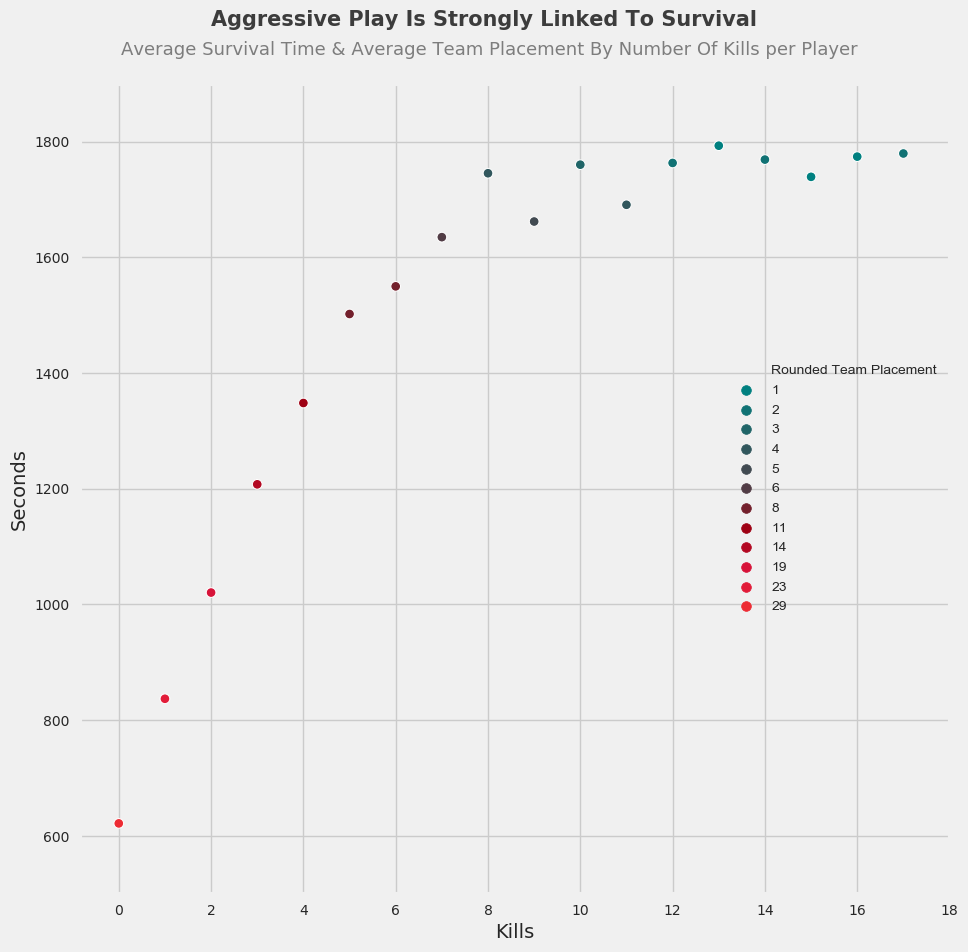

In [37]:
plt.figure(figsize = (10,10))
      
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["teal","#990011FF", 'crimson', '#ED2B33FF'])

    
    
sns.scatterplot(kills_and_survival_time_df['player_kills'], kills_and_survival_time_df['player_survive_time'], 
                hue = kills_and_survival_time_df['Rounded Team Placement'], legend="full", palette = cmap)

plt.xticks([0,2,4,6,8,10,12,14,16,18], **afont)

plt.yticks(**afont)

plt.xlabel('Kills',fontsize=14,**afont)
plt.ylabel('Seconds',fontsize=14,**afont)

plt.ylim(500,1900)


plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.axhline(y = -0.5, color = 'black', linewidth = 1.25, alpha = 1)

plt.legend(loc='right')


plt.text(x = 2, y = 2000, s = "Aggressive Play Is Strongly Linked To Survival",
               fontsize = 15, weight = 'bold', alpha = .75, color = 'black',**hfont)
plt.text(x = 0.04, y = 1950, s = 'Average Survival Time & Average Team Placement By Number Of Kills per Player',
         fontsize = 13, alpha = .85,
        color = 'dimgrey',**ofont)

plt.show()

<font color='red'> 
    
## Is camping a viable strategy?
    
</font> 

In [38]:
#create new 'total distance travelled' variable
matchesAsRows['player total distance travelled'] = matchesAsRows['player_dist_ride'] + matchesAsRows['player_dist_walk']

In [39]:
sample = matchesAsRows.sample(frac=1) #create copy of dataframe

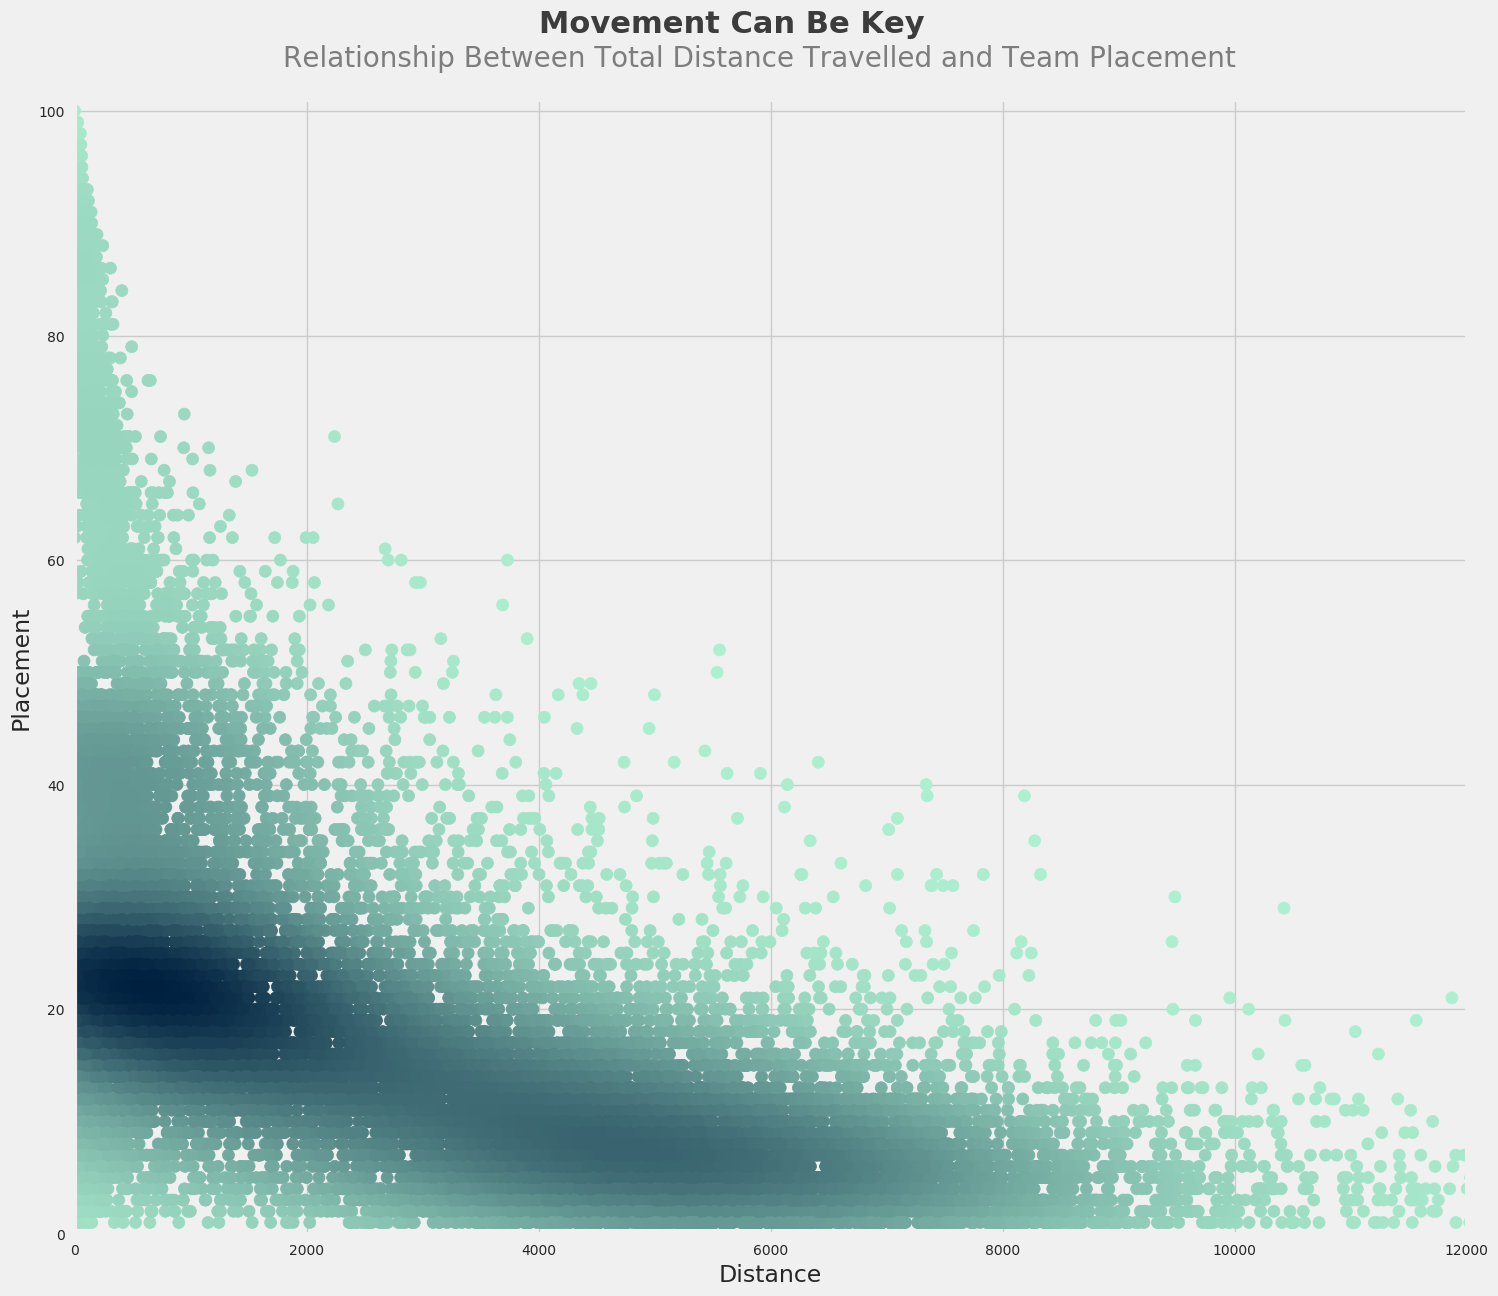

In [40]:
plt.figure(figsize=(16,14))
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ADEFD1FF",'#00203FFF'])

x = sample['player total distance travelled']
y = sample['team_placement']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z, cmap = cmap,s=75)


plt.xticks(**afont)
plt.yticks(**afont)

plt.xlabel('Distance',fontsize=17,**afont)
plt.ylabel('Placement',fontsize=17,**afont)

plt.xlim(0,12001)
plt.ylim(0,101)


plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.axhline(y = 0, color = 'black', linewidth = 1.25, alpha = 1)

plt.text(x = 4000, y = 107, s = "Movement Can Be Key",
               fontsize = 22, weight = 'bold', alpha = .75, color = 'black',**hfont)
plt.text(x = 1800, y = 104, s = 'Relationship Between Total Distance Travelled and Team Placement',
         fontsize = 20, alpha = .85, color = 'dimgrey',**ofont)


plt.show()


<font color='red'> 

## What’s the most campy you can be and still be in with a good statistical chance of winning? 
</font> 

In [41]:
#load up a larger proportion of the data

n = 50 
placeholder_df = pd.read_csv('/Users/alitaimurshabbir/Desktop/pubg-match-deaths/aggregate/agg_match_stats_0.csv', 
                            header=0, skiprows=lambda i: i % n != 0)

matchesAsRowsSolo = placeholder_df[placeholder_df['party_size']==1] #restrict to solo games

topPlacements = matchesAsRowsSolo[matchesAsRowsSolo['team_placement'] == 1] #restrict to solo game winners

In [42]:
matchesAsRowsSolo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57647 entries, 9 to 276979
Data columns (total 15 columns):
date                   57647 non-null object
game_size              57647 non-null int64
match_id               57647 non-null object
match_mode             57647 non-null object
party_size             57647 non-null int64
player_assists         57647 non-null int64
player_dbno            57647 non-null int64
player_dist_ride       57647 non-null float64
player_dist_walk       57647 non-null float64
player_dmg             57647 non-null int64
player_kills           57647 non-null int64
player_name            57544 non-null object
player_survive_time    57647 non-null float64
team_id                57647 non-null int64
team_placement         57647 non-null int64
dtypes: float64(3), int64(8), object(4)
memory usage: 7.0+ MB


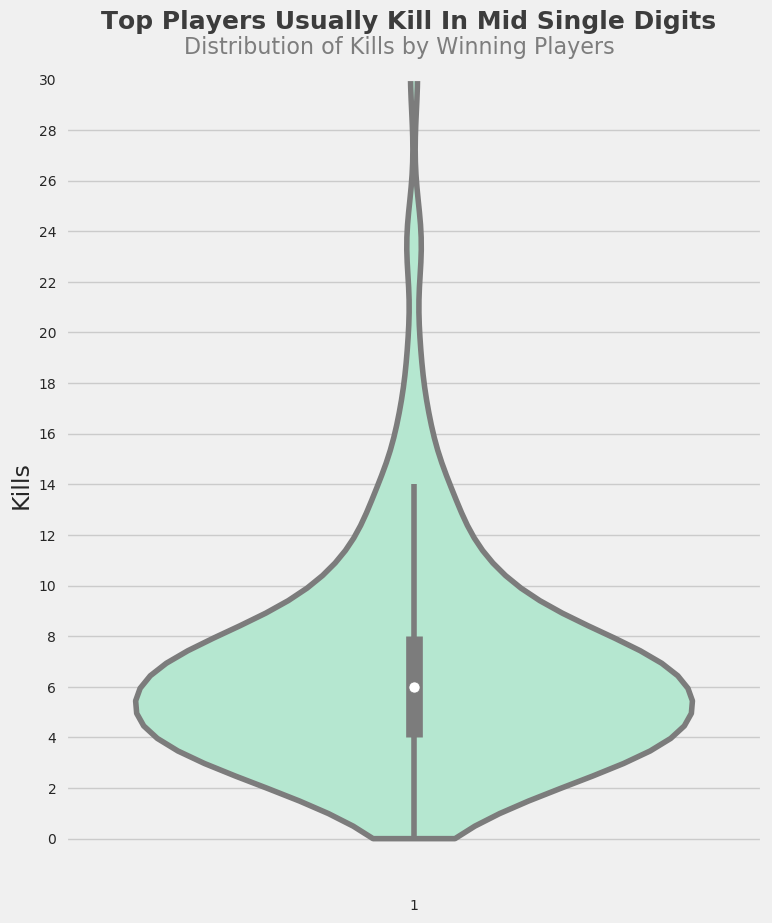

In [43]:
plt.figure(figsize=(8,10))

sns.violinplot(x='party_size', y='player_kills', data=topPlacements, labels = [],
               color = '#ADEFD1FF', cut = 0)

plt.xticks(**afont)
plt.yticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],**afont)

plt.xlabel('',fontsize=17,**afont)
plt.ylabel('Kills',fontsize=17,**afont)

plt.ylim(-2,30)

plt.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.text(x = -0.45, y = 32, s = "Top Players Usually Kill In Mid Single Digits",
               fontsize = 18, weight = 'bold', alpha = .75, color = 'black',**hfont)
plt.text(x = -0.33, y = 31, s = 'Distribution of Kills by Winning Players',
         fontsize = 16, alpha = .85,
        color = 'dimgrey',**ofont)


plt.show()